In [1]:
import pandas as pd
import numpy as np
import random
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scipy.stats import pearsonr

In [2]:
def load_df():
    label_encoder = preprocessing.LabelEncoder()

    df = pd.read_csv('data/qsar-biodeg.csv')
    df = df.dropna()
    cat = df.select_dtypes(exclude=['number'])
    for col in cat.columns:
        df[col] = label_encoder.fit_transform(df[col])

    df = df.to_numpy()
    target = df[:, -1]- 1 # Target is the last attribute
    data = df[:, :-1]   # Data is everything except the last attribute

    dataset = {'target': target,
               'data': data,
               'info': 'https://www.kaggle.com/datasets/muhammetvarl/qsarbiodegradation?resource=download',
               'date_access': '2023-10-29'}

    return dataset

In [3]:
df = load_df()
display(df)

{'target': array([1., 1., 1., ..., 0., 0., 0.]),
 'data': array([[ 3.919 ,  2.6909,  0.    , ...,  7.253 ,  0.    ,  0.    ],
        [ 4.17  ,  2.1144,  0.    , ...,  7.257 ,  0.    ,  0.    ],
        [ 3.932 ,  3.2512,  0.    , ...,  7.601 ,  0.    ,  0.    ],
        ...,
        [ 4.869 ,  1.767 ,  0.    , ...,  9.537 ,  1.    ,  0.    ],
        [ 5.158 ,  1.6914,  2.    , ..., 11.055 ,  0.    ,  1.    ],
        [ 5.076 ,  2.6588,  2.    , ...,  9.13  ,  0.    ,  2.    ]]),
 'info': 'https://www.kaggle.com/datasets/muhammetvarl/qsarbiodegradation?resource=download',
 'date_access': '2023-10-29'}

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

In [5]:
def generate_mlp(num_layers=None, layer_sizes=None, input_dim=10):
    """
    Generate a MLP with specified number of layers and layer sizes.

    Args:
    - num_layers (int): Number of hidden layers (1 to 4).
    - layer_sizes (list of int): Sizes of each hidden layer (32 to 256).
    - input_dim (int): Dimension of the input layer.

    Returns:
    - model: A compiled Keras Sequential model.
    """

    if num_layers is None:
        num_layers = np.random.randint(1, 5)
    if layer_sizes is None:
        layer_sizes = [np.random.randint(32, 257) for _ in range(num_layers)]
    
    if len(layer_sizes) != num_layers:
        raise ValueError("Length of layer_sizes must match num_layers")

    model = Sequential()
    model.add(Dense(layer_sizes[0], input_dim=input_dim, activation='relu'))

    for size in layer_sizes[1:]:
        model.add(Dense(size, activation='relu'))

    model.add(Dense(1))  # Output layer

    model.compile(optimizer='adam', loss='mse')

    return model

In [6]:
mlp_model = generate_mlp()
mlp_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 43)                473       
                                                                 
 dense_1 (Dense)             (None, 1)                 44        
                                                                 
Total params: 517 (2.02 KB)
Trainable params: 517 (2.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
def fitness_function(df, target, max_depth=1):
    
    new_feature = []

    input_dim = df['data'].shape[1]
    model = generate_mlp(input_dim=input_dim)
    value = model.predict(df['data'])
    new_feature.append(value)
        
    #MLP no lugar do generate_feature
    decision_tree = tree.DecisionTreeClassifier(max_depth=max_depth)
    decision_tree = decision_tree.fit(np.array(new_feature).reshape(-1,1), target)
    
    leaf_indices = [i for i in range(decision_tree.tree_.node_count) if decision_tree.tree_.children_left[i] == decision_tree.tree_.children_right[i]]
    gini_index = sum(decision_tree.tree_.impurity[leaf_indices]) / len(leaf_indices)
    
    return gini_index, new_feature

In [8]:
data_train, data_test, target_train, target_test = train_test_split(
    df['data'], df['target'], test_size=0.2, random_state=42)

# Teste

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def evaluate_models(df, n_iterations=1, test_size=0.2, random_state=42, new=0):
    modelos = {
        'Decision Tree': DecisionTreeClassifier(random_state=random_state),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', max_iter=1000000, random_state=random_state),
        'Random Forest': RandomForestClassifier(random_state=random_state),
        'SVM': SVC(random_state=random_state),
        'Logistic Regression': LogisticRegression(max_iter=1000000, random_state=random_state),
        'XGBoost': xgb.XGBClassifier(random_state=random_state)
    }
    acuracias = {nome_modelo: [] for nome_modelo in modelos}
    f1_scores = {nome_modelo: [] for nome_modelo in modelos}
    X_train, X_test, y_train, y_test = train_test_split(df['data'], df['target'], test_size=test_size, random_state=random_state)
    for _ in range(n_iterations):
        for nome_modelo, modelo in modelos.items():
            modelo.fit(X_train, y_train)
            val_predictions = modelo.predict(X_test)
            acuracia = accuracy_score(y_test, val_predictions)
            f1 = f1_score(y_test, val_predictions, average='weighted')
            acuracias[nome_modelo].append(acuracia)
            f1_scores[nome_modelo].append(f1)
    medias_acuracias = {nome_modelo: np.mean(acuracias[nome_modelo]) for nome_modelo in acuracias}
    medias_f1_scores = {nome_modelo: np.mean(f1_scores[nome_modelo]) for nome_modelo in f1_scores}
    if new == 0:    
        sns.set(style="whitegrid")
        model_names = list(medias_acuracias.keys())
        accuracies = list(medias_acuracias.values())
        plt.figure(figsize=(10, 6))
        colors = sns.color_palette('pastel', len(model_names))
        bars = plt.bar(model_names, accuracies, color=colors)
        for bar, accuracy in zip(bars, accuracies):
            height = bar.get_height()
            plt.annotate(f'{accuracy:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
        plt.xlabel('Modelo')
        plt.ylabel('Acurácia Média')
        plt.title('Acurácia Média de Validação dos Modelos após 1000 Iterações')
        plt.ylim(0, 1)
        plt.show()
    return medias_acuracias, medias_f1_scores


In [11]:
df = load_df()
df_new = load_df()

aux = pd.DataFrame(df_new['data'])
gine_score, new_feature = fitness_function(df, df['target'])

aux['new_feature'] = np.array(new_feature).reshape(-1,1)
aux = aux.to_numpy()

df_new['data'] = aux


33/33 [==============================] - 0s 948us/step


33/33 [==============================] - 0s 733us/step


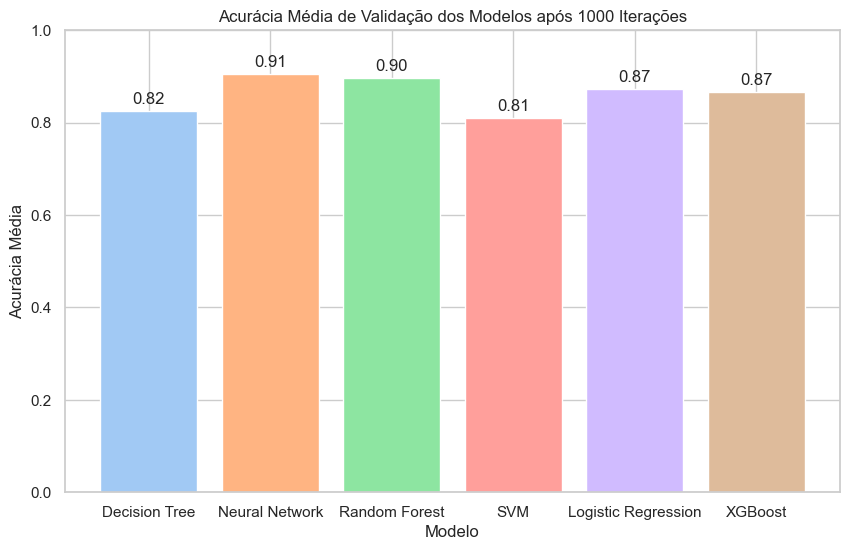

33/33 [==============================] - 0s 923us/step


In [12]:
df = load_df()
df_new = load_df()
aux = pd.DataFrame(df_new['data'])
gine_score, new_feature = fitness_function(df, df['target'])
aux['new_feature'] = np.array(new_feature).reshape(-1, 1)
aux = aux.to_numpy()
df_new['data'] = aux

evaluate_models(df)

resultados = []
f1_scores = []
gine = []

for _ in range(1000):
    df_new = load_df()
    aux = pd.DataFrame(df_new['data'])
    gine_score, new_feature = fitness_function(df_new, df_new['target'])
    aux['new_feature'] = np.array(new_feature).reshape(-1, 1)
    aux = aux.to_numpy()
    df_new['data'] = aux
    resultado, f1 = evaluate_models(df_new, new=1)
    resultado = np.array(list(resultado.values()))
    f1 = np.array(list(f1.values()))
    resultados.append(resultado)
    f1_scores.append(f1)
    gine.append(gine_score)

gine = np.array(gine)
resultados = np.array(resultados)
f1_scores = np.array(f1_scores)

df_gine = pd.DataFrame({'gine': gine})
df_resultados = pd.DataFrame(resultados, columns=['Decision Tree', 'Neural Network', 'Random Forest', 'SVM', 'Logistic Regression', 'XGBoost'])
df_f1_scores = pd.DataFrame(f1_scores, columns=['F1 Decision Tree', 'F1 Neural Network', 'F1 Random Forest', 'F1 SVM', 'F1 Logistic Regression', 'F1 XGBoost'])

df_final = pd.concat([df_gine, df_resultados], axis=1)

correlations = []
p_values = []

for f1_col in df_f1_scores.columns:
    corr, p_val = pearsonr(df_final['gine'], df_f1_scores[f1_col])
    correlations.append(corr)
    p_values.append(p_val)

df_correlations = pd.DataFrame({
    'Model': df_f1_scores.columns,
    'Correlation': correlations,
    'P-Value': p_values
})

df_resultados.to_csv('resultados.csv', index=False)
df_f1_scores.to_csv('f1_scores.csv', index=False)
df_correlations.to_csv('correlations.csv', index=False)